In [1]:
from support import *

#Initial setup
meas_datadir = './Data/5Qidle'
dh.set_datadir(meas_datadir)

measurement_control = MeasurementControl("measurement_control")
instrument_coordinator = InstrumentCoordinator("instrument_coordinator")

#Device setup
single_qubit_device = QuantumDevice("single_qubit_device")
single_qubit_device.instr_instrument_coordinator(instrument_coordinator.name)

q0 = BasicTransmonElement("q0")
single_qubit_device.add_element(q0)

#Cluster setup
cluster = Cluster(
    "cluster",
    dummy_cfg={
        1: ClusterType.CLUSTER_QRM,
        2: ClusterType.CLUSTER_QCM_RF,
    },
)
ic_cluster = ClusterComponent(cluster)
instrument_coordinator.add_component(ic_cluster)

hardware_comp_cfg = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        f"{cluster.name}": {
            "instrument_type": "Cluster",
            "ref": "internal",
            "modules": {
                "1": {
                    "instrument_type": "QRM_RF"
                },
                "2": {
                    "instrument_type": "QCM_RF"
                },
            },
        },
    },
    "hardware_options": {
        "modulation_frequencies": {
            "q0:res-q0.ro": {"lo_freq": 5.9e9},
            "q0:mw-q0.01": {"lo_freq": 3.9e9},
        },
    },
    "connectivity": {
        "graph": [
            (f"{cluster.name}.{cluster.module1.name.split('_')[-1]}.complex_output_0", "q0:res"),
            (f"{cluster.name}.{cluster.module2.name.split('_')[-1]}.complex_output_0", "q0:mw")
        ]
    },
}
# Tie hardware config to device
single_qubit_device.hardware_config(hardware_comp_cfg)


In [27]:

q0.measure.pulse_amp(0.15)
q0.clock_freqs.readout(6e9)
q0.clock_freqs.f01(4e9)
q0.rxy.amp180(0.1)

q0.reset.duration(100e-6)
q0.measure.pulse_duration(10e-6)
q0.measure.acq_delay(100e-9)
q0.measure.integration_time(1.5e-6)


In [3]:
def pulse_preview(quantum_device:QuantumDevice,sche_func:Schedule, sche_kwargs:dict, **kwargs):
    
    pio.renderers.default='browser'
    device_compiler = SerialCompiler("Device compiler", quantum_device)
    comp_sched = device_compiler.compile(
        sche_func(**sche_kwargs)
    )
    sche_func(**sche_kwargs).plot_circuit_diagram()
    comp_sched.plot_pulse_diagram(plot_backend="plotly",**kwargs).show()

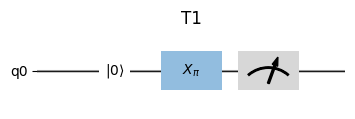

In [4]:
from quantify_scheduler.operations.gate_library import X

def t1_sched(times, repetitions=1):
    schedule = Schedule("T1", repetitions)
    for i, tau in enumerate(times):
        schedule.add(Reset("q0"), label=f"Reset {i}")
        schedule.add(X("q0"), label=f"pi {i}")
        schedule.add(
            Measure("q0", acq_index=i),
            ref_pt="start",
            rel_time=tau,
            label=f"Measurement {i}",
        )
    return schedule

t1_schedule = t1_sched
t1_sched_kwargs = dict(
    times = [1e-6],
)

pulse_preview(single_qubit_device, t1_schedule, t1_sched_kwargs)

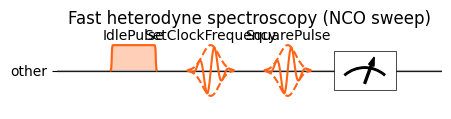

In [13]:
freq = np.array([6e9])

res_sched = heterodyne_spec_sched_nco
spec_sched_kwargs = dict(    # *** Try to draw the prospective wave as a plot for a great check of the outputting pulse. And turn them into parameters
    pulse_amp=0.1,           # *** Check the unit of amplitude, only scale or volt # Can be set as a parameter
    pulse_duration=2e-6,     # *** Can be set as a parameter
    frequencies=freq,
    acquisition_delay=80e-9,# *** Can be set as a parameter
    integration_time=1.5e-6,   # *** Can be set as a parameter
    port=q0.ports.readout(),
    clock=q0.name + ".ro",
    init_duration=10e-6,     # *** Can be set as a parameter
)

pulse_preview(single_qubit_device, res_sched, spec_sched_kwargs)

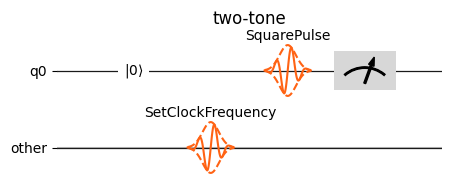

In [28]:
freq = np.array([4e9])
def two_tone_spec_sched_nco(
    qubit_name: str,
    spec_pulse_amp: float,
    spec_pulse_duration: float,
    spec_pulse_port: str,
    spec_pulse_clock: str,
    spec_pulse_frequencies: np.ndarray,
    repetitions: int = 1,
) -> Schedule:
    """
    Generate a batched schedule for performing fast two-tone spectroscopy using the
    `SetClockFrequency` operation for doing an NCO sweep.

    Parameters
    ----------
    spec_pulse_amp
        Amplitude of the spectroscopy pulse in Volt.
    spec_pulse_duration
        Duration of the spectroscopy pulse in seconds.
    spec_pulse_port
        Location on the device where the spectroscopy pulse should be applied.
    spec_pulse_clock
        Reference clock used to track the spectroscopy frequency.
    spec_pulse_frequencies
        Sample frequencies for the spectroscopy pulse in Hertz.
    repetitions
        The amount of times the Schedule will be repeated.
    """
    sched = Schedule("two-tone", repetitions)
    sched.add_resource(ClockResource(name=spec_pulse_clock, freq=spec_pulse_frequencies.flat[0]))

    for acq_idx, spec_pulse_freq in enumerate(spec_pulse_frequencies):
        sched.add(Reset(qubit_name))
        sched.add(SetClockFrequency(clock=spec_pulse_clock, clock_freq_new=spec_pulse_freq))
        sched.add(
            SquarePulse(
                duration=spec_pulse_duration,
                amp=spec_pulse_amp,
                port=spec_pulse_port,
                clock=spec_pulse_clock,
            )
        )
        sched.add(Measure(qubit_name, acq_index=acq_idx))

    return sched

two_tone_sched = two_tone_spec_sched_nco
qubit_spec_sched_kwargs = dict(
            qubit_name=q0.name,
            spec_pulse_amp=0.1,
            spec_pulse_duration=2e-5,
            spec_pulse_port=q0.ports.microwave(),
            spec_pulse_clock=q0.name + ".01",
            spec_pulse_frequencies=freq
        )

pulse_preview(single_qubit_device, two_tone_sched, qubit_spec_sched_kwargs)